In [ ]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns
import shap

# Start by importing the data

In [2]:
df = pd.read_csv('titanic.csv', header=0)

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Sort the data

In [4]:
# change the sex data to integer values
df['Sex'].replace('male', 0, inplace=True)
df['Sex'].replace('female', 1, inplace=True)

In [5]:
# drop the name, passenger ID,  ticket number columns as they aren't needed for the algorithm
df.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)

### removing cabin data as there are too many missing values

could reintroduce this data in some form later to investigate the impact of the values we do have

In [6]:
# remove cabin data as too much is missing.
df.drop('Cabin', axis=1, inplace=True)

remove NaN values

In [7]:
df = df.dropna()

### Investigate the values in the Embarked columns to decide how we will classify them as integer values

In [8]:
# find the number of unique ports and the number of passengers that embarked from each port
df.Embarked.value_counts()

S    781
C    212
Q     50
Name: Embarked, dtype: int64

convert to integer values

In [9]:
df['Embarked'].replace('S', 0, inplace=True)
df['Embarked'].replace('C', 1, inplace=True)
df['Embarked'].replace('Q', 2, inplace=True)

In [10]:
# don't know why but pandas coverted to floats, so conver to ints
df['Embarked'] = df['Embarked'].astype(int)

## have a look at our cleaned dataframe

In [11]:
print(df.head())
print()
print(df.describe())
print()
print(df.shape[0])

   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0         0       3    0  22.0      1      0   7.2500         0
1         1       1    1  38.0      1      0  71.2833         1
2         1       3    1  26.0      0      0   7.9250         0
3         1       1    1  35.0      1      0  53.1000         0
4         0       3    0  35.0      0      0   8.0500         0

          Survived       Pclass          Sex          Age        SibSp  \
count  1043.000000  1043.000000  1043.000000  1043.000000  1043.000000   
mean      0.397891     2.209012     0.370086    29.813202     0.504314   
std       0.489697     0.840685     0.483059    14.366254     0.913080   
min       0.000000     1.000000     0.000000     0.170000     0.000000   
25%       0.000000     1.000000     0.000000    21.000000     0.000000   
50%       0.000000     2.000000     0.000000    28.000000     0.000000   
75%       1.000000     3.000000     1.000000    39.000000     1.000000   
max       1.000000     

### so we've lost around 300 pieces of data (people) by removing NaN values. we'll continue but might want to revisit this

# Create an ANN
could revisit and try KNN, but no obvious trends linking any of the features to if they survived

## plot scatter plots to how the features are related to the survived status

In [12]:
# get a list of the features so we can plot them

header_list = list(df.columns.values)
features_list = header_list.remove('Survived')

<function matplotlib.pyplot.show(close=None, block=None)>

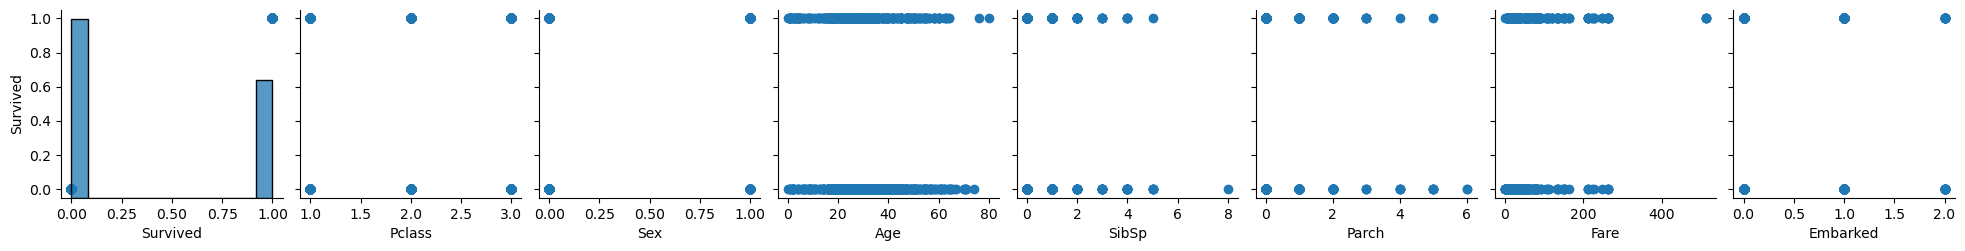

In [13]:
# create graphs to see how the different features are affecting the Survived status

g = sns.pairplot(df, y_vars = ['Survived'], x_vars=features_list, kind='scatter', plot_kws={'alpha':0.1})
g.map(plt.scatter);
plt.show


## splitting and training the model

In [14]:
X = df.drop('Survived', axis='columns')
y = df['Survived']
# ensure all data are floating point values
X = X.astype('float32')
# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(698, 7) (345, 7) (698,) (345,)


In [15]:
# determine the number of input features
n_features = X_train.shape[1]

print(n_features)

7


In [ ]:
# define model
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(10, activation='softplus', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(2, activation='sigmoid'))

In [17]:
# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
# fit the model
history = model.fit(X_train, y_train, epochs=600, batch_size=32, verbose=1, validation_data=(X_test,y_test))

Epoch 1/600
22/22 [==============================] - 0s 6ms/step - loss: 11.2906 - val_loss: 6.9692
Epoch 2/600
22/22 [==============================] - 0s 2ms/step - loss: 6.7871 - val_loss: 3.7930
Epoch 3/600
22/22 [==============================] - 0s 2ms/step - loss: 3.9262 - val_loss: 2.3198
Epoch 4/600
22/22 [==============================] - 0s 2ms/step - loss: 2.3110 - val_loss: 1.3598
Epoch 5/600
22/22 [==============================] - 0s 2ms/step - loss: 1.3610 - val_loss: 0.9097
Epoch 6/600
22/22 [==============================] - 0s 2ms/step - loss: 0.9319 - val_loss: 0.6947
Epoch 7/600
22/22 [==============================] - 0s 2ms/step - loss: 0.7814 - val_loss: 0.6941
Epoch 8/600
22/22 [==============================] - 0s 2ms/step - loss: 0.7498 - val_loss: 0.6785
Epoch 9/600
22/22 [==============================] - 0s 2ms/step - loss: 0.7327 - val_loss: 0.6692
Epoch 10/600
22/22 [==============================] - 0s 2ms/step - loss: 0.7333 - val_loss: 0.6736
Epoch 11

In [18]:
# predict test set
yhat = model.predict(X_test)
classes = np.argmax(yhat,axis=1)
# evaluate predictions
score = accuracy_score(y_test, classes)
print('Accuracy: %.3f' % score)

11/11 [==============================] - 0s 659us/step
Accuracy: 0.841


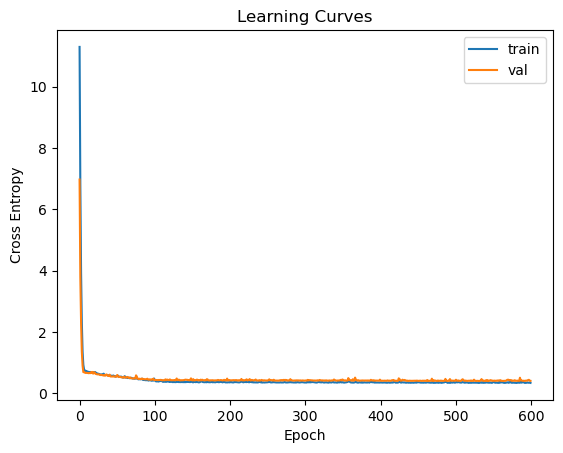

In [19]:
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [20]:
# save first model
model.save("model.h1")

INFO:tensorflow:Assets written to: model.h1/assets


# make a new model
## model_2

In [21]:
# define model
model_2 = Sequential()
model_2.add(Dense(16, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model_2.add(Dense(16, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model_2.add(Dense(2, activation='sigmoid'))

In [22]:
# compile the model
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
# fit the model
history_2 = model_2.fit(X_train, y_train, epochs=600, batch_size=32, verbose=1, validation_data=(X_test,y_test))

Epoch 1/600
22/22 [==============================] - 0s 5ms/step - loss: 8.5967 - val_loss: 3.8263
Epoch 2/600
22/22 [==============================] - 0s 2ms/step - loss: 4.2095 - val_loss: 3.0851
Epoch 3/600
22/22 [==============================] - 0s 2ms/step - loss: 3.2935 - val_loss: 2.3981
Epoch 4/600
22/22 [==============================] - 0s 2ms/step - loss: 2.5553 - val_loss: 1.8866
Epoch 5/600
22/22 [==============================] - 0s 2ms/step - loss: 2.0297 - val_loss: 1.4710
Epoch 6/600
22/22 [==============================] - 0s 2ms/step - loss: 1.5875 - val_loss: 1.1892
Epoch 7/600
22/22 [==============================] - 0s 2ms/step - loss: 1.2956 - val_loss: 0.9885
Epoch 8/600
22/22 [==============================] - 0s 2ms/step - loss: 1.0985 - val_loss: 0.8611
Epoch 9/600
22/22 [==============================] - 0s 2ms/step - loss: 0.9216 - val_loss: 0.7451
Epoch 10/600
22/22 [==============================] - 0s 2ms/step - loss: 0.8032 - val_loss: 0.6570
Epoch 11/

In [23]:
# predict test set
yhat = model_2.predict(X_test)
classes = np.argmax(yhat,axis=1)
# evaluate predictions
score = accuracy_score(y_test, classes)
print('Accuracy: %.3f' % score)

11/11 [==============================] - 0s 619us/step
Accuracy: 0.858


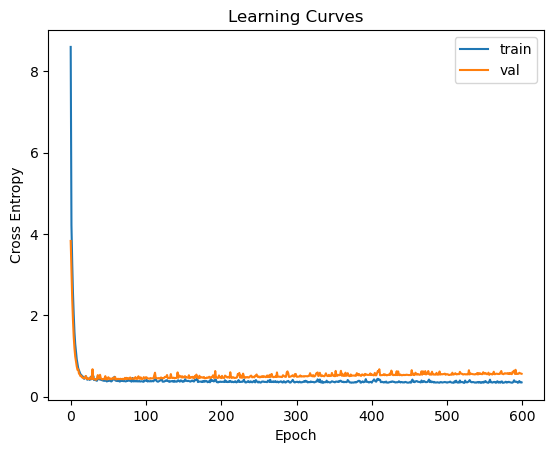

In [24]:
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history_2.history['loss'], label='train')
plt.plot(history_2.history['val_loss'], label='val')
plt.legend()
plt.show()

## make a new model - model 3

add a sigmoid activation function

In [37]:
# define model
# lets add loads of layers to see what happens
model_3 = Sequential()
model_3.add(Dense(16, activation='selu', kernel_initializer='he_normal', input_shape=(n_features,)))
model_3.add(Dense(10, activation='elu', kernel_initializer='he_normal', input_shape=(n_features,)))
model_3.add(Dense(10, activation='leaky_relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model_3.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model_3.add(Dense(10, activation='tanh', kernel_initializer='he_normal', input_shape=(n_features,)))
model_3.add(Dense(2, activation='sigmoid'))

In [38]:
# compile the model
model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
# fit the model
history_3 = model_3.fit(X_train, y_train, epochs=600, batch_size=32, verbose=1, validation_data=(X_test,y_test))

Epoch 1/600
22/22 [==============================] - 0s 6ms/step - loss: 0.7454 - val_loss: 0.7024
Epoch 2/600
22/22 [==============================] - 0s 2ms/step - loss: 0.6838 - val_loss: 0.6596
Epoch 3/600
22/22 [==============================] - 0s 2ms/step - loss: 0.6587 - val_loss: 0.6284
Epoch 4/600
22/22 [==============================] - 0s 2ms/step - loss: 0.6427 - val_loss: 0.6088
Epoch 5/600
22/22 [==============================] - 0s 2ms/step - loss: 0.6368 - val_loss: 0.5946
Epoch 6/600
22/22 [==============================] - 0s 2ms/step - loss: 0.6286 - val_loss: 0.5932
Epoch 7/600
22/22 [==============================] - 0s 2ms/step - loss: 0.6267 - val_loss: 0.5862
Epoch 8/600
22/22 [==============================] - 0s 2ms/step - loss: 0.6225 - val_loss: 0.5790
Epoch 9/600
22/22 [==============================] - 0s 2ms/step - loss: 0.6139 - val_loss: 0.5949
Epoch 10/600
22/22 [==============================] - 0s 2ms/step - loss: 0.6172 - val_loss: 0.5706
Epoch 11/

In [39]:
# predict test set
yhat = model_3.predict(X_test)
classes = np.argmax(yhat,axis=1)
# evaluate predictions
score = accuracy_score(y_test, classes)
print('Accuracy: %.3f' % score)

11/11 [==============================] - 0s 690us/step
Accuracy: 0.835


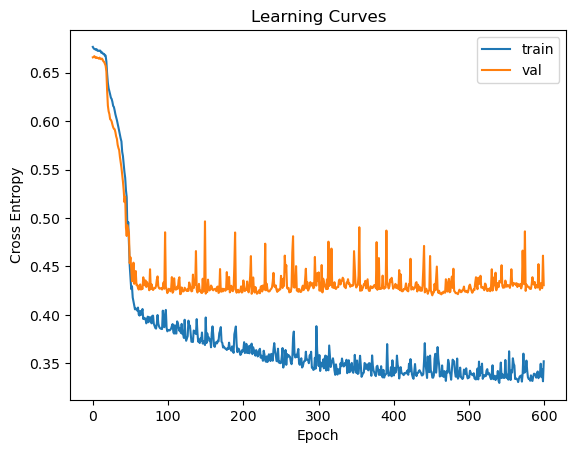

In [33]:
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history_3.history['loss'], label='train')
plt.plot(history_3.history['val_loss'], label='val')
plt.legend()
plt.show()

Looks to be overfitting the data


# Analyse the contribution of the different features using Shapley Values

can't get this working yet 

seems like i need to downgrade to an earlier version of tensorflow

In [ ]:
shap_values = shap.DeepExplainer(model, df).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")